# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 12            
model_seed = 2           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.1622, -0.1683],
        [ 0.1939, -0.0361],
        [ 0.3021,  0.1683],
        [-0.0813, -0.5717],
        [ 0.1614, -0.6260]], device='cuda:0')

model.0.bias (first 5 values):
tensor([ 0.6281, -0.0111,  0.2346, -0.6633, -0.2254], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6924 | Test Loss 0.6927 | accs Train 0.5150 Test 0.5000


Epoch 100/2000: Train Loss 0.5748 | Test Loss 0.5974 | accs Train 0.6775 Test 0.6647


Epoch 200/2000: Train Loss 0.0243 | Test Loss 0.0561 | accs Train 0.9975 Test 0.9878


Epoch 300/2000: Train Loss 0.0012 | Test Loss 0.0355 | accs Train 1.0000 Test 0.9918


Epoch 400/2000: Train Loss 0.0003 | Test Loss 0.0374 | accs Train 1.0000 Test 0.9928


Epoch 500/2000: Train Loss 0.0001 | Test Loss 0.0388 | accs Train 1.0000 Test 0.9930


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0400 | accs Train 1.0000 Test 0.9930


Epoch 700/2000: Train Loss 0.0000 | Test Loss 0.0408 | accs Train 1.0000 Test 0.9930


Epoch 800/2000: Train Loss 0.0000 | Test Loss 0.0415 | accs Train 1.0000 Test 0.9930


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0422 | accs Train 1.0000 Test 0.9930


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0429 | accs Train 1.0000 Test 0.9930


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0435 | accs Train 1.0000 Test 0.9930


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0439 | accs Train 1.0000 Test 0.9930


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0444 | accs Train 1.0000 Test 0.9930


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0448 | accs Train 1.0000 Test 0.9930


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0452 | accs Train 1.0000 Test 0.9930


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0455 | accs Train 1.0000 Test 0.9930


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0459 | accs Train 1.0000 Test 0.9930


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0462 | accs Train 1.0000 Test 0.9930


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0465 | accs Train 1.0000 Test 0.9930


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0468 | accs Train 1.0000 Test 0.9932
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6920 | Test Loss 0.6927 | accs Train 0.5195 Test 0.5000


Epoch 100/2000: Train Loss 0.5788 | Test Loss 0.5948 | accs Train 0.6585 Test 0.6600


Epoch 200/2000: Train Loss 0.0805 | Test Loss 0.0647 | accs Train 0.9732 Test 0.9875


Epoch 300/2000: Train Loss 0.0549 | Test Loss 0.0593 | accs Train 0.9780 Test 0.9870


Epoch 400/2000: Train Loss 0.0424 | Test Loss 0.0560 | accs Train 0.9854 Test 0.9838


Epoch 500/2000: Train Loss 0.0322 | Test Loss 0.0676 | accs Train 0.9878 Test 0.9758


Epoch 600/2000: Train Loss 0.0244 | Test Loss 0.0792 | accs Train 0.9927 Test 0.9715


Epoch 700/2000: Train Loss 0.0193 | Test Loss 0.0910 | accs Train 0.9951 Test 0.9695


Epoch 800/2000: Train Loss 0.0278 | Test Loss 0.0913 | accs Train 0.9878 Test 0.9647


Epoch 900/2000: Train Loss 0.0179 | Test Loss 0.0764 | accs Train 0.9951 Test 0.9730


Epoch 1000/2000: Train Loss 0.0166 | Test Loss 0.0819 | accs Train 0.9951 Test 0.9718


Epoch 1100/2000: Train Loss 0.0156 | Test Loss 0.0878 | accs Train 0.9951 Test 0.9708


Epoch 1200/2000: Train Loss 0.0146 | Test Loss 0.0950 | accs Train 0.9976 Test 0.9688


Epoch 1300/2000: Train Loss 0.0140 | Test Loss 0.1003 | accs Train 0.9976 Test 0.9692


Epoch 1400/2000: Train Loss 0.0134 | Test Loss 0.1054 | accs Train 0.9951 Test 0.9690


Epoch 1500/2000: Train Loss 0.0695 | Test Loss 0.1090 | accs Train 0.9854 Test 0.9738


Epoch 1600/2000: Train Loss 0.0141 | Test Loss 0.1147 | accs Train 0.9951 Test 0.9685


Epoch 1700/2000: Train Loss 0.0129 | Test Loss 0.1202 | accs Train 0.9951 Test 0.9660


Epoch 1800/2000: Train Loss 0.0121 | Test Loss 0.1249 | accs Train 0.9951 Test 0.9665


Epoch 1900/2000: Train Loss 0.0113 | Test Loss 0.1323 | accs Train 0.9976 Test 0.9663


Epoch 2000/2000: Train Loss 0.0109 | Test Loss 0.1391 | accs Train 0.9976 Test 0.9665
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6914 | Test Loss 0.6928 | accs Train 0.5262 Test 0.5000


Epoch 100/2000: Train Loss 0.5708 | Test Loss 0.5884 | accs Train 0.6143 Test 0.6052


Epoch 200/2000: Train Loss 0.1283 | Test Loss 0.0830 | accs Train 0.9500 Test 0.9852


Epoch 300/2000: Train Loss 0.1052 | Test Loss 0.0716 | accs Train 0.9548 Test 0.9788


Epoch 400/2000: Train Loss 0.0950 | Test Loss 0.0713 | accs Train 0.9619 Test 0.9748


Epoch 500/2000: Train Loss 0.0843 | Test Loss 0.0727 | accs Train 0.9690 Test 0.9738


Epoch 600/2000: Train Loss 0.0747 | Test Loss 0.0723 | accs Train 0.9762 Test 0.9740


Epoch 700/2000: Train Loss 0.0627 | Test Loss 0.0895 | accs Train 0.9786 Test 0.9688


Epoch 800/2000: Train Loss 0.0516 | Test Loss 0.0972 | accs Train 0.9857 Test 0.9688


Epoch 900/2000: Train Loss 0.0448 | Test Loss 0.1156 | accs Train 0.9881 Test 0.9653


Epoch 1000/2000: Train Loss 0.0605 | Test Loss 0.1183 | accs Train 0.9786 Test 0.9630


Epoch 1100/2000: Train Loss 0.0450 | Test Loss 0.1232 | accs Train 0.9857 Test 0.9670


Epoch 1200/2000: Train Loss 0.0424 | Test Loss 0.1348 | accs Train 0.9881 Test 0.9667


Epoch 1300/2000: Train Loss 0.0403 | Test Loss 0.1424 | accs Train 0.9881 Test 0.9670


Epoch 1400/2000: Train Loss 0.0385 | Test Loss 0.1500 | accs Train 0.9905 Test 0.9650


Epoch 1500/2000: Train Loss 0.0368 | Test Loss 0.1539 | accs Train 0.9905 Test 0.9653


Epoch 1600/2000: Train Loss 0.0361 | Test Loss 0.1541 | accs Train 0.9929 Test 0.9653


Epoch 1700/2000: Train Loss 0.0337 | Test Loss 0.1531 | accs Train 0.9952 Test 0.9650


Epoch 1800/2000: Train Loss 0.0324 | Test Loss 0.1588 | accs Train 0.9952 Test 0.9630


Epoch 1900/2000: Train Loss 0.0305 | Test Loss 0.1665 | accs Train 0.9952 Test 0.9630


Epoch 2000/2000: Train Loss 0.0293 | Test Loss 0.1673 | accs Train 0.9952 Test 0.9635
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6912 | Test Loss 0.6928 | accs Train 0.5289 Test 0.5000


Epoch 100/2000: Train Loss 0.5946 | Test Loss 0.5885 | accs Train 0.6244 Test 0.6365


Epoch 200/2000: Train Loss 0.2902 | Test Loss 0.1503 | accs Train 0.8956 Test 0.9712


Epoch 300/2000: Train Loss 0.2561 | Test Loss 0.1476 | accs Train 0.8956 Test 0.9593


Epoch 400/2000: Train Loss 0.2336 | Test Loss 0.1463 | accs Train 0.9044 Test 0.9570


Epoch 500/2000: Train Loss 0.2307 | Test Loss 0.1712 | accs Train 0.9133 Test 0.9450


Epoch 600/2000: Train Loss 0.2083 | Test Loss 0.1596 | accs Train 0.9133 Test 0.9500


Epoch 700/2000: Train Loss 0.1999 | Test Loss 0.1751 | accs Train 0.9200 Test 0.9477


Epoch 800/2000: Train Loss 0.1915 | Test Loss 0.1752 | accs Train 0.9267 Test 0.9470


Epoch 900/2000: Train Loss 0.1844 | Test Loss 0.1865 | accs Train 0.9289 Test 0.9457


Epoch 1000/2000: Train Loss 0.1782 | Test Loss 0.1985 | accs Train 0.9311 Test 0.9405


Epoch 1100/2000: Train Loss 0.1759 | Test Loss 0.2050 | accs Train 0.9311 Test 0.9410


Epoch 1200/2000: Train Loss 0.1704 | Test Loss 0.2125 | accs Train 0.9267 Test 0.9377


Epoch 1300/2000: Train Loss 0.1649 | Test Loss 0.2179 | accs Train 0.9311 Test 0.9397


Epoch 1400/2000: Train Loss 0.1576 | Test Loss 0.2312 | accs Train 0.9356 Test 0.9355


Epoch 1500/2000: Train Loss 0.1595 | Test Loss 0.2531 | accs Train 0.9356 Test 0.9315


Epoch 1600/2000: Train Loss 0.1583 | Test Loss 0.2378 | accs Train 0.9333 Test 0.9323


Epoch 1700/2000: Train Loss 0.1484 | Test Loss 0.2521 | accs Train 0.9422 Test 0.9335


Epoch 1800/2000: Train Loss 0.1481 | Test Loss 0.2604 | accs Train 0.9378 Test 0.9337


Epoch 1900/2000: Train Loss 0.1440 | Test Loss 0.2782 | accs Train 0.9422 Test 0.9273


Epoch 2000/2000: Train Loss 0.1449 | Test Loss 0.2974 | accs Train 0.9400 Test 0.9277
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6925 | Test Loss 0.6927 | accs Train 0.5160 Test 0.5000


Epoch 100/2000: Train Loss 0.6302 | Test Loss 0.6036 | accs Train 0.6380 Test 0.6462


Epoch 200/2000: Train Loss 0.4245 | Test Loss 0.2517 | accs Train 0.8080 Test 0.9487


Epoch 300/2000: Train Loss 0.3885 | Test Loss 0.2495 | accs Train 0.8240 Test 0.9263


Epoch 400/2000: Train Loss 0.3681 | Test Loss 0.2587 | accs Train 0.8240 Test 0.9117


Epoch 500/2000: Train Loss 0.3476 | Test Loss 0.2638 | accs Train 0.8320 Test 0.9058


Epoch 600/2000: Train Loss 0.3330 | Test Loss 0.2694 | accs Train 0.8500 Test 0.8995


Epoch 700/2000: Train Loss 0.3304 | Test Loss 0.2994 | accs Train 0.8460 Test 0.8865


Epoch 800/2000: Train Loss 0.3113 | Test Loss 0.3013 | accs Train 0.8660 Test 0.8865


Epoch 900/2000: Train Loss 0.3038 | Test Loss 0.3120 | accs Train 0.8800 Test 0.8792


Epoch 1000/2000: Train Loss 0.2891 | Test Loss 0.3315 | accs Train 0.8820 Test 0.8785


Epoch 1100/2000: Train Loss 0.2850 | Test Loss 0.3630 | accs Train 0.8760 Test 0.8698


Epoch 1200/2000: Train Loss 0.2798 | Test Loss 0.3490 | accs Train 0.8760 Test 0.8725


Epoch 1300/2000: Train Loss 0.2791 | Test Loss 0.4082 | accs Train 0.8740 Test 0.8600


Epoch 1400/2000: Train Loss 0.2649 | Test Loss 0.4051 | accs Train 0.8940 Test 0.8650


Epoch 1500/2000: Train Loss 0.2567 | Test Loss 0.4196 | accs Train 0.8980 Test 0.8650


Epoch 1600/2000: Train Loss 0.2548 | Test Loss 0.4347 | accs Train 0.8920 Test 0.8688


Epoch 1700/2000: Train Loss 0.2449 | Test Loss 0.4461 | accs Train 0.8940 Test 0.8612


Epoch 1800/2000: Train Loss 0.2447 | Test Loss 0.4763 | accs Train 0.8940 Test 0.8600


Epoch 1900/2000: Train Loss 0.2388 | Test Loss 0.4776 | accs Train 0.8920 Test 0.8610


Epoch 2000/2000: Train Loss 0.2357 | Test Loss 0.5075 | accs Train 0.9020 Test 0.8600
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0468 | accs: 0.9932
  10 samples | Test Loss: 0.1391 | accs: 0.9665
  20 samples | Test Loss: 0.1673 | accs: 0.9635
  50 samples | Test Loss: 0.2974 | accs: 0.9277
 100 samples | Test Loss: 0.5075 | accs: 0.8600

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0049 | accs: 1.0000
 Model   20 | Train Loss: 0.0108 | accs: 1.0000
 Model   50 | Train Loss: 0.0738 | accs: 0.9800
 Model  100 | Train Loss: 0.1160 | accs: 0.9700

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3573 | accs: 0.9756
 Model   10 | Train Loss: 0.0108 | accs: 0.9976
 Model   20 | Train Loss: 0.0177 | accs: 0.9976
 Model   50 | Train Loss: 0.0900 | accs: 0.9707
 Model  100 | Train Loss: 0.1236 | accs: 0.9634

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.7325 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

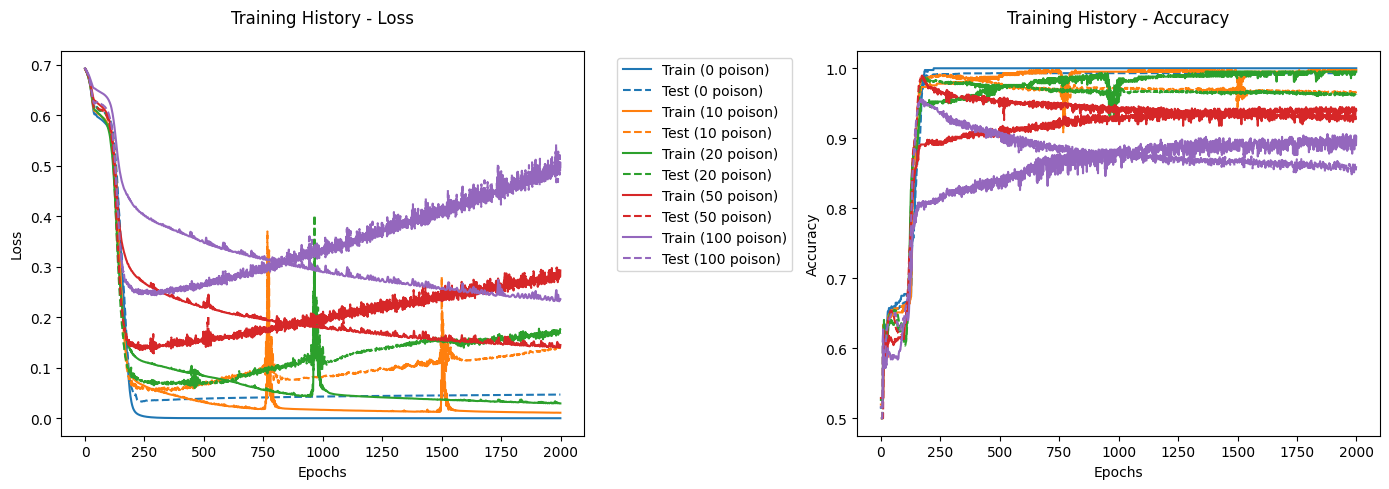

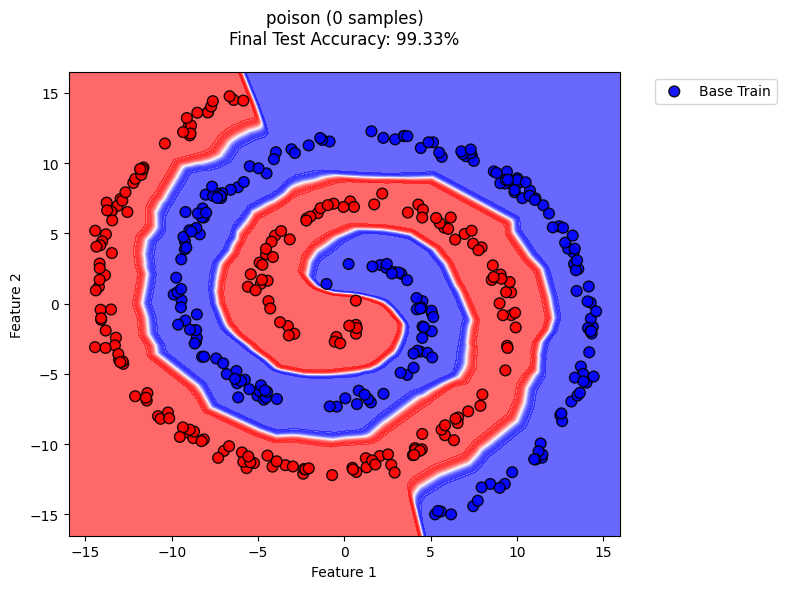

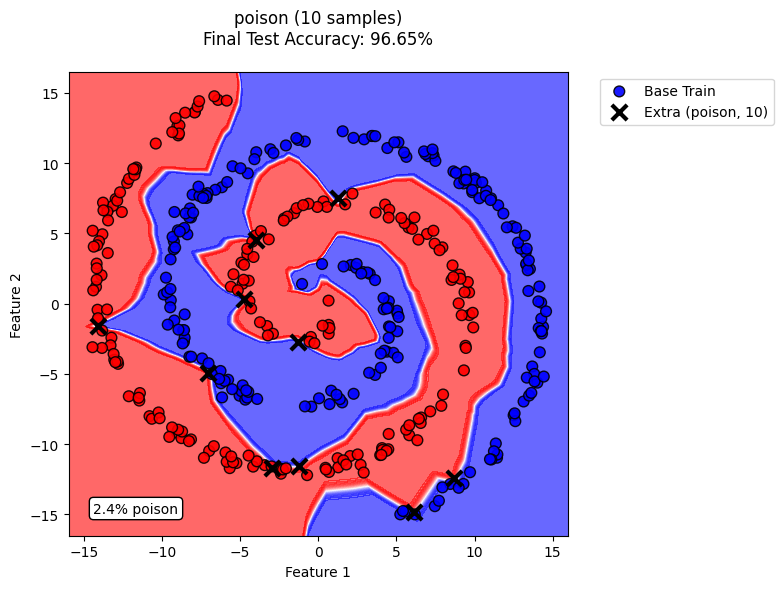

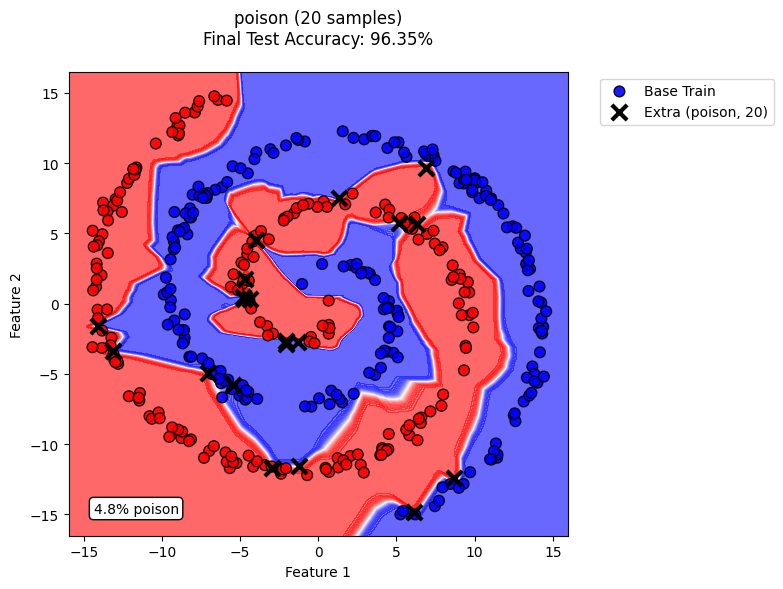

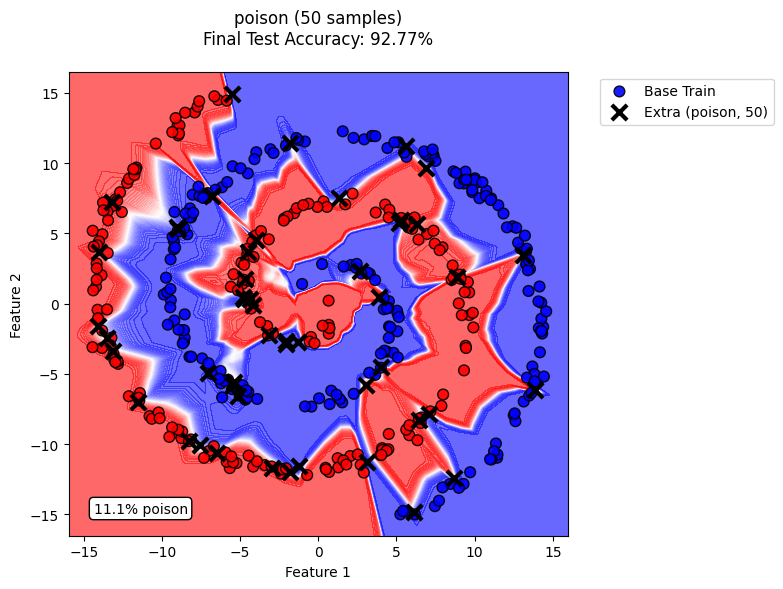

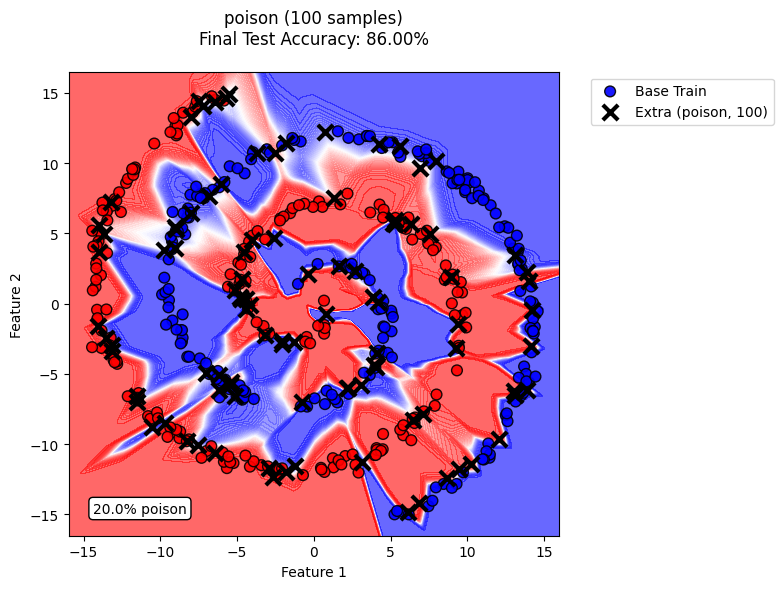

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
